# 0. 데이터 로드

In [1]:
import pandas as pd


total_data = pd.read_csv('./reviews/tokenized_data.csv')
total_data['tokenized'] = total_data['tokenized'].apply(lambda x: str(x).split())

211848
   label   count
0      0   70616
1      1  141232


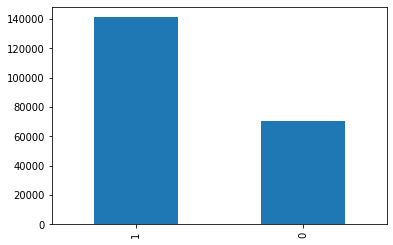

In [2]:
import matplotlib.pyplot as plt


total_data['label'].value_counts().plot(kind = 'bar')
print(len(total_data))
print(total_data.groupby('label').size().reset_index(name = 'count'))

# 1. 데이터 분리

In [3]:
from sklearn.model_selection import train_test_split


train_data, test_data = train_test_split(total_data, test_size = 0.2, random_state = 42)

X_train = train_data['tokenized'].values
y_train = train_data['label'].values

X_test = test_data['tokenized'].values
y_test = test_data['label'].values

169478
   label   count
0      0   56429
1      1  113049


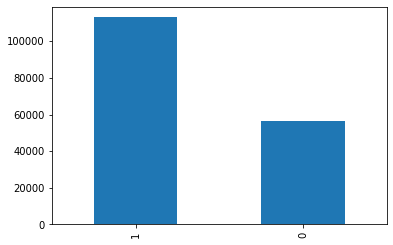

In [4]:
train_data['label'].value_counts().plot(kind = 'bar')
print(len(train_data))
print(train_data.groupby('label').size().reset_index(name = 'count'))

# 2. 정수형 인코딩

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer


def above_threshold_freq(X_train, min_freq):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(X_train)

    threshold = min_freq
    
    total_cnt = len(tokenizer.word_index)
    rare_cnt = 0
    total_freq = 0
    rare_freq = 0

    for key, value in tokenizer.word_counts.items():
        total_freq += value
        if(value < threshold):
            rare_cnt = rare_cnt + 1
            rare_freq = rare_freq + value

    print('단어 집합(vocabulary)의 크기 :',total_cnt)
    print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
    print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
    print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)
    

    vocab_size = total_cnt - rare_cnt + 2
    print('단어 집합의 크기 :',vocab_size)


    return vocab_size

In [6]:
min_freq = 2
vocab_size = above_threshold_freq(X_train, min_freq)

단어 집합(vocabulary)의 크기 : 51544
등장 빈도가 1번 이하인 희귀 단어의 수: 11846
단어 집합에서 희귀 단어의 비율: 22.982306379015988
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.22604635648613364
단어 집합의 크기 : 39700


In [7]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# 3. 패팅

리뷰의 최대 길이 : 208
리뷰의 평균 길이 : 30.92152373759426


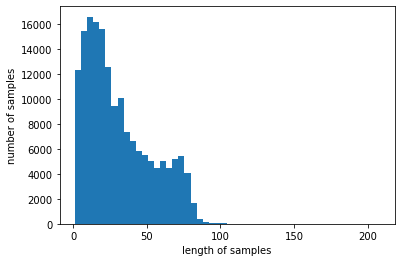

In [8]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [9]:
def below_threshold_len(X_train, max_len):
    cnt = 0
    for sent in X_train:
        if(len(sent) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(X_train))*100))

In [10]:
max_len = 40
below_threshold_len(X_train, max_len=max_len)

전체 샘플 중 길이가 40 이하인 샘플의 비율: 70.10408430592761


In [11]:
from tensorflow.keras.preprocessing.sequence import pad_sequences


X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

# 4. 학습

In [14]:
# from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf

embedding_size = 100
hidden_size = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_size))
model.add(GRU(hidden_size))
model.add(Dense(1, activation='sigmoid'))

# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint(
    f'./result/gru/f{min_freq}_l{max_len}_e{embedding_size}_h{hidden_size}/best_model.h5', 
    monitor='val_acc', mode='max', verbose=1, save_best_only=True
)
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [15]:
# history = model.fit(X_train, y_train, epochs=20, callbacks=[es, mc], batch_size=60, validation_split=0.2)
history = model.fit(X_train, y_train, epochs=20, callbacks=[mc], batch_size=60, validation_split=0.2)

Epoch 1/20


CancelledError:  [_Derived_]RecvAsync is cancelled.
	 [[{{node assert_less_equal/Assert/AssertGuard/else/_11/assert_less_equal/Assert/AssertGuard/Assert/data_1/_86}}]]
	 [[assert_less_equal_1/All/_64]] [Op:__inference_train_function_7395]

Function call stack:
train_function


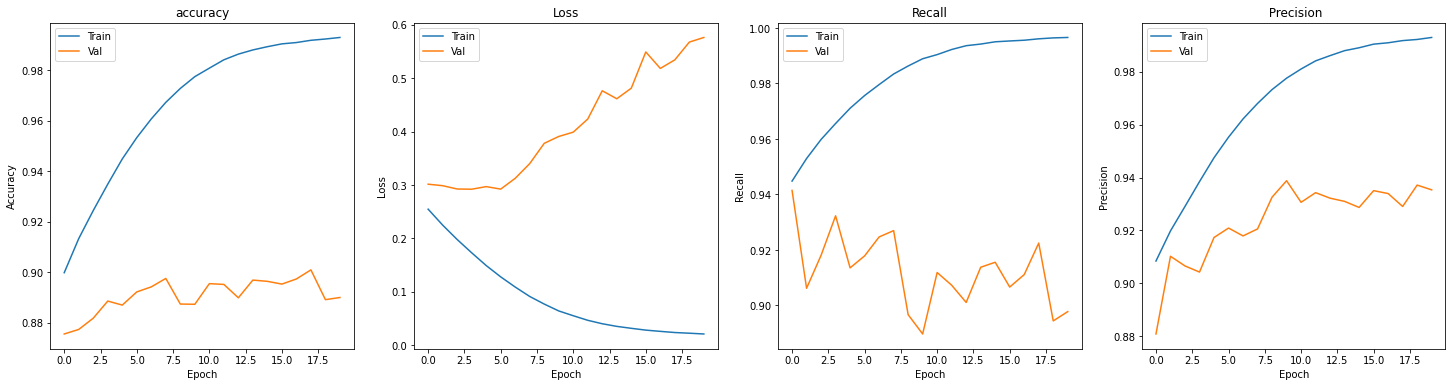

In [17]:
plt.figure(figsize=(25, 6))
plt.subplot(1, 4, 1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(1, 4, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(1, 4, 3)
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(1, 4, 4)
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title(' Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Train', 'Val'], loc='upper left')

plt.savefig(f'./result/gru/f{min_freq}_l{max_len}_e{embedding_size}_h{hidden_size}/alrp.png')

# 5. 평가

In [18]:
from tensorflow.keras.models import load_model


loaded_model = load_model(f'./result/gru/f{min_freq}_l{max_len}_e{embedding_size}_h{hidden_size}/best_model.h5')

In [19]:
evaluate_list = loaded_model.evaluate(X_test, y_test)
print("\n 테스트 정확도: %.4f" % evaluate_list[1])

1325/1325 [==============================] - 10s 7ms/step - loss: 0.5426 - acc: 0.8989 - recall: 0.9227 - precision: 0.9251

 테스트 정확도: 0.8989


In [20]:
for eval in evaluate_list:
    print("\n 평과 결과 리스트 ?: %.4f" % eval)


 평과 결과 리스트 ?: 0.5426

 평과 결과 리스트 ?: 0.8989

 평과 결과 리스트 ?: 0.9227

 평과 결과 리스트 ?: 0.9251


In [21]:
def predict_text(tokenized_reviews):
    # 정수 인코딩
    encoded_reviews = tokenizer.texts_to_sequences(tokenized_reviews)

    # 패딩
    padded_reviews = pad_sequences(encoded_reviews, maxlen = max_len)
    
    # 예측
    scores = loaded_model.predict(padded_reviews)
                                  
    return scores

In [22]:
test_data['score'] = predict_text(test_data['tokenized'])
test_data['predict'] = [1 if score > 0.5 else 0 for score in test_data['score']]
test_data['score'] = test_data['score'].apply(lambda x: int(x * 100) if x > 0.5 else int((1 - x) * 100))

c:\users\multicampus\desktop\tf_gpu\venv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
c:\users\multicampus\desktop\tf_gpu\venv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\multicampus\desktop\tf_gpu\venv\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

In [23]:
_test_data = test_data[['lael', 'predict','rating','score', 'review','tokenized']]

In [24]:
positiveg_data = _test_data[_test_data['label'] == 1]
positive_wrong_data = positiveg_data[positiveg_data['predict'] == 0]
print(positive_wrong_data.head(5))

negative_data = _test_data[_test_data['label'] == 0]
negative_wrong_data = negative_data[negative_data['predict'] == 1]
print(negative_wrong_data.head(5))

        label  predict  rating  score  \
93833       1        0      10     99   
68067       1        0      10     50   
61365       1        0      10     89   
73625       1        0      10     99   
171098      1        0      10     65   

                                                   review  \
93833   귀스타브가 꿰뚫어 본 군중 심리는 200년 이 지난 지금도 적용되는 것 같다. 군중...   
68067                           언제나 우리 마음속에 살아 계실 김희준 시인님   
61365   인간은 노력하는 한 방황하는 법이니라. 선한 인간이란 어두운 충동 속에서도 올바른 ...   
73625   상식 사전, 이런 책 팔이 시리즈 별로 좋아하지 않습니다만, 이 책은 제목만 부끄럽...   
171098                                      번역 출간돼서 반가운 책   

                                                tokenized  
93833   [귀스타브/NNP, 가/JKS, 꿰뚫/VV, 어/EC, 본/VX+ETM, 군중/NN...  
68067   [언제나/MAG, 우리/NP, 마음/NNG, 속/NNG, 에/JKB, 살/VV, 아...  
61365   [인간/NNG, 은/JX, 노력/NNG, 하/XSV, 는/ETM, 한/MM, 방황/...  
73625   [상식/NNG, 사전/NNG, 이런/MM, 책/NNG, 팔/NNG, 이/JKS, 시...  
171098     [번역/NNG, 출간/NNG, 돼서/XSV+EC, 반가운/VA+ETM, 책/NNG]  
        label  predict  ra

In [25]:
positive_wrong_data.to_csv(f'./result/gru/f{min_freq}_l{max_len}_e{embedding_size}_h{hidden_size}/positive_wrong_data.csv', index=False)
negative_wrong_data.to_csv(f'./result/gru/f{min_freq}_l{max_len}_e{embedding_size}_h{hidden_size}/negative_wrong_data.csv', index=False)